We would like to calculate the confidence interval for precision of a model in the presence of unreliable labels. Consider the following data, where the observed counts of TPs and FPs are based on unreliable labels.

In [1]:
tp_observed = 5285
fp_observed = 3184

What does the distribution of precision look like if we do not account for mislabelling and assume for the moment that the labels are perfect? [Goutte and Gaussier](https://pdfs.semanticscholar.org/e399/9a46cb8aaf71131a77670da5c5c113aad01d.pdf) showed that precision follows the Beta distribution with the counts of TPs and FPs as parameters, adjusted for prior. We will use uniform prior, $Beta(1,1)$.

In [3]:
import pymc3 as pm

with pm.Model() as model:
    precision_reliable = pm.Beta('precision_reliable', tp_observed + 1, fp_observed + 1)

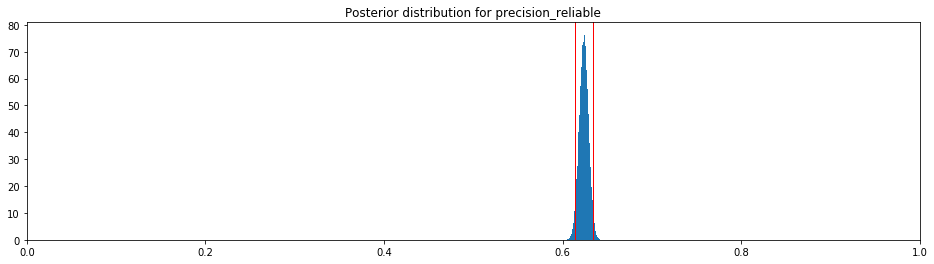

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import numpy as np

def plot_dist(variable, confidence_level_percent=95):
    figsize(16, 4)
    samples = variable.random(size=100000)
    _, ax = plt.subplots()
    plt.hist(samples, bins=100, normed=True, histtype="stepfilled")
    plt.title("Posterior distribution for %s" % variable.name)
    plt.xlim(0, 1)
    conf_interval_min = np.percentile(samples, (100-confidence_level_percent) / 2),
    conf_interval_max = np.percentile(samples, confidence_level_percent  +  (100-confidence_level_percent) / 2)
    ax.axvline(x=conf_interval_min, ymin=0, ymax=1, color='r', linewidth=1)
    ax.axvline(x=conf_interval_max, ymin=0, ymax=1, color='r', linewidth=1)
    
    
plot_dist(precision_reliable)

We subsequently reviewed randomly selected observed TPs and FPs, 100 from each group, and counted how many of them had incorrect labels.

In [5]:
reviewed_tp = 100
mislabelled_tp = 7
reviewed_fp = 100
mislabelled_fp = 31

How can we account for the mislabelling when calculating the posterior of precision? Let us try to model the mislabelling rates using a Beta distribution, parameterised by the available evidence of mislabelling.

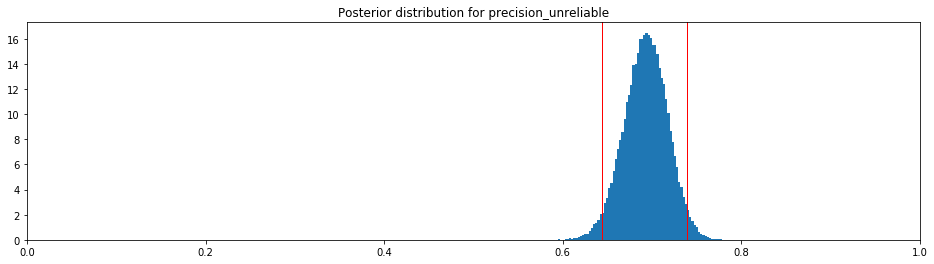

In [6]:
with pm.Model() as model:
    mislabel_rate_tp = pm.Beta('mislabel_rate_tp', mislabelled_tp + 1, reviewed_tp - mislabelled_tp + 1)
    mislabel_rate_fp = pm.Beta('mislabel_rate_fp', mislabelled_fp + 1, reviewed_fp - mislabelled_fp + 1)
    tp_actual = tp_observed * (1-mislabel_rate_tp) + fp_observed * mislabel_rate_fp
    fp_actual = fp_observed * (1-mislabel_rate_fp) + tp_observed * mislabel_rate_tp
    precision_unreliable = pm.Beta('precision_unreliable', tp_actual + 1, fp_actual + 1)

plot_dist(precision_unreliable)